<a href="https://colab.research.google.com/github/XuRui314/Kaggle-Practice/blob/main/Detailed_Marketing_Cohort%2C_Pareto%2C_RFM%2C_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 

drive.mount('/content/gdrive/') 

Mounted at /content/gdrive/


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/kaggle/Customer_Segmentation")
!ls

 data.csv   data.csv.zip  'SimHei .ttf'


In [4]:
from matplotlib.font_manager import fontManager
import matplotlib as mpl
import matplotlib.pyplot as plt 

fontManager.addfont('SimHei .ttf')
mpl.rc('font', family='SimHei')

# Start

这个其实是基于之前的那个案例，利用不同的商业模型进一步去分析，这里利用到的模型有：Cohort组群分析，Pareto二八定律，RFM客户价值模型，还有Facebook的时序预测模型Prophet。

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

首先是对于数据的基本分析，包括缺失值的分析和处理，还有对价格等特征的统计画图：

In [7]:
df = pd.read_csv("data.csv",encoding="ISO-8859-1")
display(df.head())
print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


(541909, 8)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df[df.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [11]:
df[df.Description.isnull()].CustomerID.nunique()

0

In [12]:
df[df.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

In [13]:
df = df[df.Description.notnull()]

In [14]:
df[df.CustomerID.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [15]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.CustomerID.notnull()]

print("We have {} observations after removing unknown customers.".format(df.shape[0]))

We have 540455 observations.
We have 406829 observations after removing unknown customers.


In [16]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [17]:
df[df.Description.str.len() < 5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [18]:
df.InvoiceNo.value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
554155      1
570248      1
545414      1
545418      1
565192      1
Name: InvoiceNo, Length: 22190, dtype: int64

In [19]:
df[df["InvoiceNo"].str.startswith("C")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [20]:
df["Cancelled"] = df["InvoiceNo"].apply(lambda x: 1 if x.startswith("C") else 0)

In [21]:
cancelled_invoiceNo = df[df.Cancelled == 1].InvoiceNo.tolist()
cancelled_invoiceNo = [x[1:] for x in cancelled_invoiceNo]

cancelled_invoiceNo[:5]

['536379', '536383', '536391', '536391', '536391']

In [22]:
df[df["InvoiceNo"].isin(cancelled_invoiceNo)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled


In [23]:
df[df.InvoiceNo.str.len() != 6]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom,1
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom,1
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom,1
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom,1


In [24]:
df = df[df.Cancelled == 0]

In [25]:
df[df.StockCode.str.contains("^[a-zA-Z]")].StockCode.value_counts()

POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

In [26]:
df[df.StockCode.str.contains("^[a-zA-Z]")].Description.value_counts()

POSTAGE                       1099
Manual                         290
CARRIAGE                       133
DOTCOM POSTAGE                  16
Bank Charges                    12
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64

In [27]:
df[df.StockCode.str.len() > 5].StockCode.value_counts()

85123A    2035
85099B    1618
82494L     820
85099F     664
85099C     659
          ... 
35610C       1
90187B       1
90190A       1
90190B       1
90214Z       1
Name: StockCode, Length: 875, dtype: int64

In [28]:
df[df.StockCode.str.len() > 5].Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2028
JUMBO BAG RED RETROSPOT                1618
WOODEN FRAME ANTIQUE WHITE              820
JUMBO BAG STRAWBERRY                    664
JUMBO  BAG BAROQUE BLACK WHITE          659
                                       ... 
PURPLE/BLUE CERAMIC CANDLE HOLDER         1
ORANGE PENDANT TRIPLE SHELL NECKLAC       1
ROSE PENDANT TRIPLE SHELL NECKLACE        1
BLACK CHRISTMAS FLOCK DROPLET             1
CURIOUS IMAGES SCRAP BOOK SET             1
Name: Description, Length: 887, dtype: int64

In [29]:
df =  df[~ df.StockCode.str.contains("^[a-zA-Z]")]

In [30]:
df["Description"] = df["Description"].str.lower()

In [31]:
df.groupby("StockCode")["Description"].nunique()[df.groupby("StockCode")["Description"].nunique() != 1]

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
         ..
85184C    2
85185B    2
90014A    2
90014B    2
90014C    2
Name: Description, Length: 213, dtype: int64

In [32]:
df[df.StockCode == "16156L"].Description.value_counts()

wrap carousel     14
wrap, carousel     4
Name: Description, dtype: int64

In [33]:
df[df.StockCode == "17107D"].Description.value_counts()

flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: Description, dtype: int64

In [34]:
df[df.StockCode == "90014C"].Description.value_counts()

silver/black orbit necklace        2
silver and black orbit necklace    1
Name: Description, dtype: int64

In [35]:
df.CustomerID.value_counts()

17841.0    7838
14911.0    5591
14096.0    5095
12748.0    4580
14606.0    2697
           ... 
14705.0       1
13841.0       1
17715.0       1
18084.0       1
13099.0       1
Name: CustomerID, Length: 4335, dtype: int64

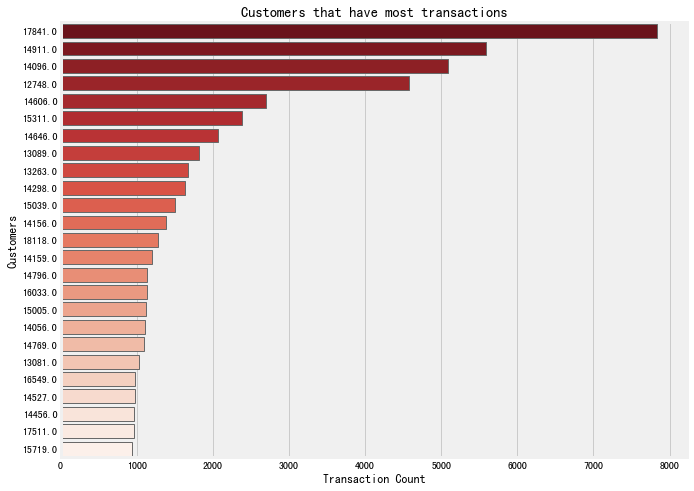

In [36]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "Reds_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()


In [37]:
df.Country.value_counts()

United Kingdom          354005
Germany                   8659
France                    8034
EIRE                      7138
Spain                     2423
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1425
Australia                 1184
Norway                    1049
Channel Islands            744
Italy                      741
Finland                    647
Cyprus                     612
Sweden                     428
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     248
Unspecified                244
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

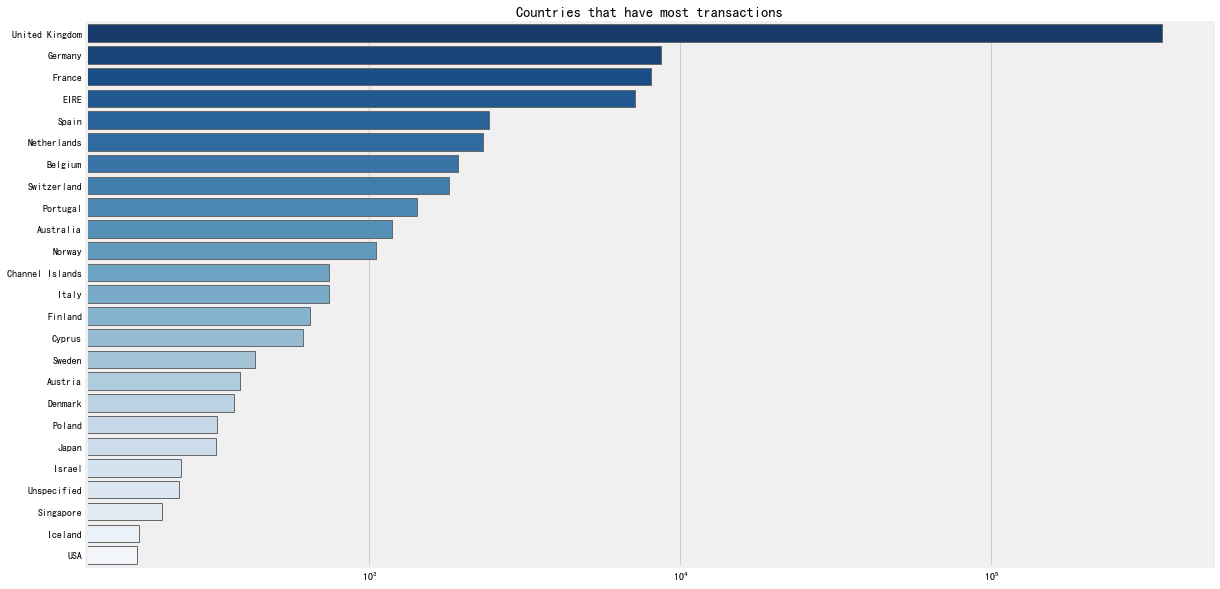

In [38]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Blues_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

In [39]:
df["UnitPrice"].describe()

count    396370.000000
mean          2.867983
std           4.264566
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [40]:
df[df.UnitPrice == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
9302,537197,22841,round cake tin vintage green,1,12/5/2010 14:02,0.0,12647.0,Germany,0
33576,539263,22580,advent calendar gingham sack,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0
40089,539722,22423,regency cakestand 3 tier,10,12/21/2010 13:45,0.0,14911.0,EIRE,0
47068,540372,22090,paper bunting retrospot,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
47070,540372,22553,plasters in tin skulls,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0


In [41]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.UnitPrice > 0]

print("We have {} observations after removing records that have 0 unit price.".format(df.shape[0]))

We have 396370 observations.
We have 396337 observations after removing records that have 0 unit price.


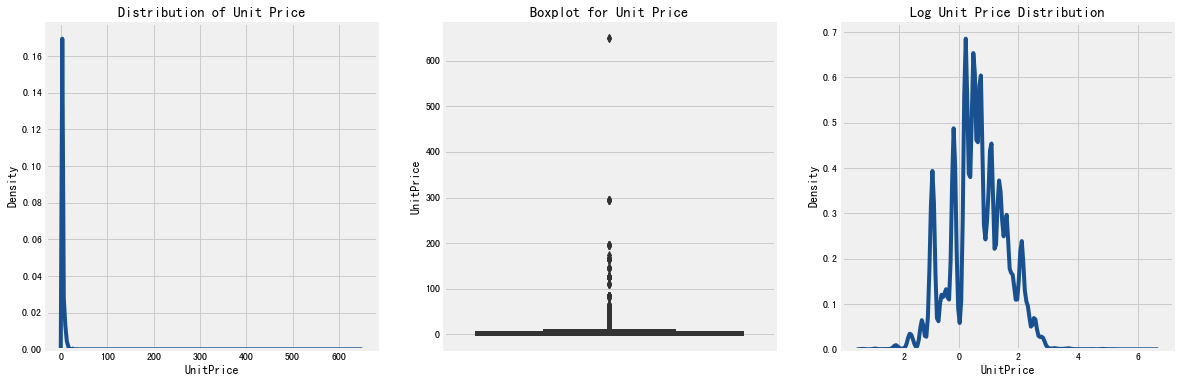

In [42]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

plt.show()

In [44]:
np.quantile(df.UnitPrice, 0.99)

12.75

In [45]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.UnitPrice > 0.1) & (df.UnitPrice < 20)]

print("We have {} observations after removing unit prices smaller than 0.1 and greater than 20.".format(df.shape[0]))

We have 396337 observations.
We have 395385 observations after removing unit prices smaller than 0.1 and greater than 20.


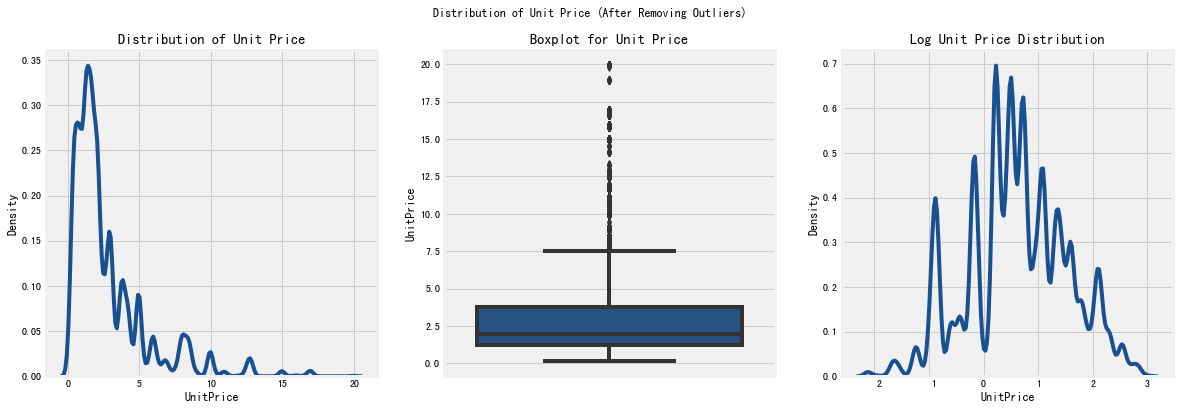

In [46]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

In [47]:
df["Quantity"].describe()

count    395385.000000
mean         12.946075
std         179.665683
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

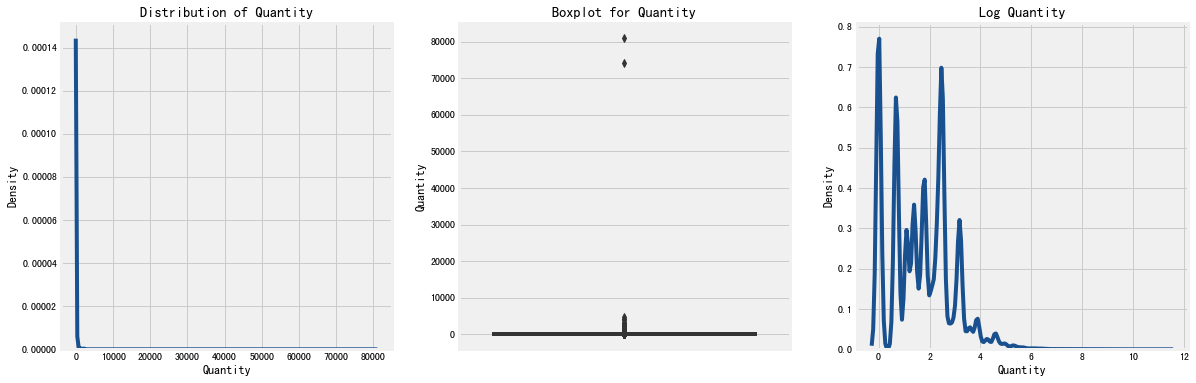

In [48]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
plt.show()

In [49]:
print("Upper limit for Quantity: " + str(np.exp(5)))

Upper limit for Quantity: 148.4131591025766


In [50]:
np.quantile(df.Quantity, 0.99)

120.0

In [51]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.Quantity < 150)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 395385 observations.
We have 392735 observations after removing quantities greater than 150.


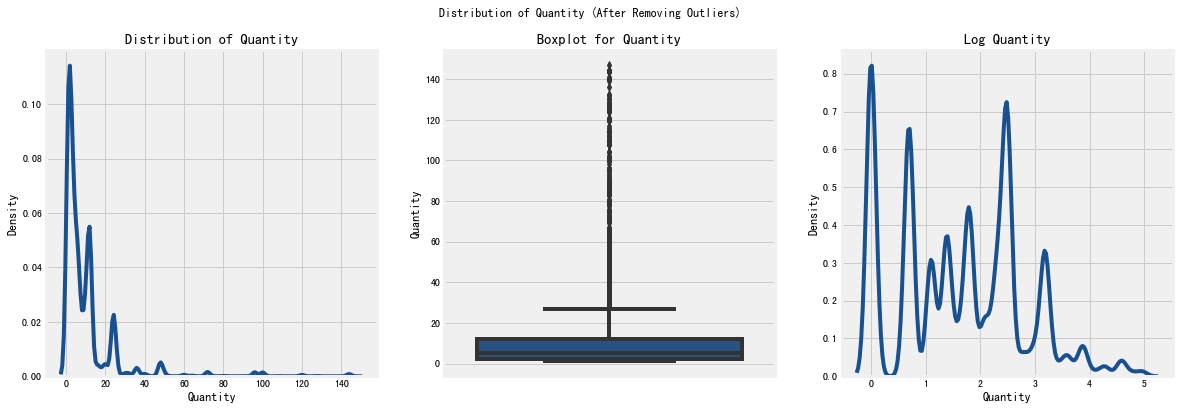

In [52]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [53]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.drop("Cancelled", axis = 1, inplace = True)
df.to_csv("online_retail_final.csv", index = False)

# Part 1: Cohort Analysis

Cohort Analysis 是一种简单成熟的分析方法，不但能够告诉我们用户在什么时候离开了我们的产品，而且能进一步告诉我们用户为什么离开，帮助我们找到优化产品的方法。



群组分析是按照首次访问的时间，和下一次访问的间隔来计算留存情况。这就需要记录下来每一条会话对应用户的首次访问时间，和这次会话与首次访问的时间间隔。得到的就是不同顾客的一条条订单，分别有该顾客最早的购物时间（也就是所属分的组），还有这次订单距离第一次购物的时间，用于最终表格每一行的数据统计。

In [54]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))
print("Time difference is: {}".format(df.InvoiceDate.max() - df.InvoiceDate.min()))


Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00
Time difference is: 373 days 04:24:00


In [58]:
import datetime as dt

def get_month(x): return dt.datetime(x.year, x.month, 1) 

def get_dates(df, col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day


In [59]:
df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)

# 不再是只显示合并后的对应项，而是保持了与原始数据集相同数量的项目，这样就很好继续了。这就是transform的独特之处。
df["CohortMonth"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min") 



In [62]:
invoice_year, invoice_month, invoice_day = get_dates(df, "InvoiceMonth")
cohort_year, cohort_month, cohort_day = get_dates(df, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df["CohortIndex"] = 12 * year_diff + month_diff + 1

In [68]:
cohort_data = df.groupby(["CohortIndex", "CohortMonth"])["CustomerID"].nunique().reset_index()
cohort_data

,CohortIndex,CohortMonth,CustomerID
0,1,2010-12-01,874
1,1,2011-01-01,409
2,1,2011-02-01,375
3,1,2011-03-01,450
4,1,2011-04-01,297
...,...,...,...
86,11,2011-01-01,151
87,11,2011-02-01,25
88,12,2010-12-01,440
89,12,2011-01-01,48


In [63]:
# pivot是重新组织数据的方法，相当于按照所选行和列把数据对应铺平
cohort_pivot = cohort_data.pivot(index = "CohortMonth", columns = "CohortIndex", values = "CustomerID")

cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,874.0,319.0,280.0,329.0,317.0,350.0,316.0,303.0,304.0,345.0,327.0,440.0,231.0
2011-01-01,409.0,91.0,112.0,94.0,131.0,119.0,103.0,100.0,123.0,135.0,151.0,48.0,NaN
2011-02-01,375.0,68.0,69.0,103.0,100.0,90.0,94.0,100.0,92.0,115.0,25.0,NaN,NaN
2011-03-01,450.0,66.0,111.0,90.0,101.0,75.0,119.0,104.0,124.0,38.0,NaN,NaN,NaN
2011-04-01,297.0,64.0,61.0,61.0,56.0,68.0,65.0,77.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,280.0,55.0,48.0,49.0,59.0,65.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,240.0,42.0,38.0,64.0,54.0,78.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,189.0,34.0,39.0,42.0,50.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,170.0,32.0,41.0,41.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


计算用户留存率，说白了就是每列除以第一列的数据：
![](https://images.ctfassets.net/vrkkgjbn4fsk/7KUaWGQ9IJvf85OheLucgk/e03a27e5c68cc317b38dda354fee504d/how_to_calculate_user_retention_rate)

In [69]:
cohort_sizes = cohort_pivot.iloc[:, 0]

retention = cohort_pivot.divide(cohort_sizes, axis = 0)
retention.index = retention.index.strftime("%Y-%m")

retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.364989,0.320366,0.376430,0.362700,0.400458,0.361556,0.346682,0.347826,0.394737,0.374142,0.503432,0.264302
2011-01,1.0,0.222494,0.273839,0.229829,0.320293,0.290954,0.251834,0.244499,0.300733,0.330073,0.369193,0.117359,NaN
2011-02,1.0,0.181333,0.184000,0.274667,0.266667,0.240000,0.250667,0.266667,0.245333,0.306667,0.066667,NaN,NaN
2011-03,1.0,0.146667,0.246667,0.200000,0.224444,0.166667,0.264444,0.231111,0.275556,0.084444,NaN,NaN,NaN
2011-04,1.0,0.215488,0.205387,0.205387,0.188552,0.228956,0.218855,0.259259,0.074074,NaN,NaN,NaN,NaN
2011-05,1.0,0.196429,0.171429,0.175000,0.210714,0.232143,0.267857,0.092857,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.175000,0.158333,0.266667,0.225000,0.325000,0.095833,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.179894,0.206349,0.222222,0.264550,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.188235,0.241176,0.241176,0.129412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


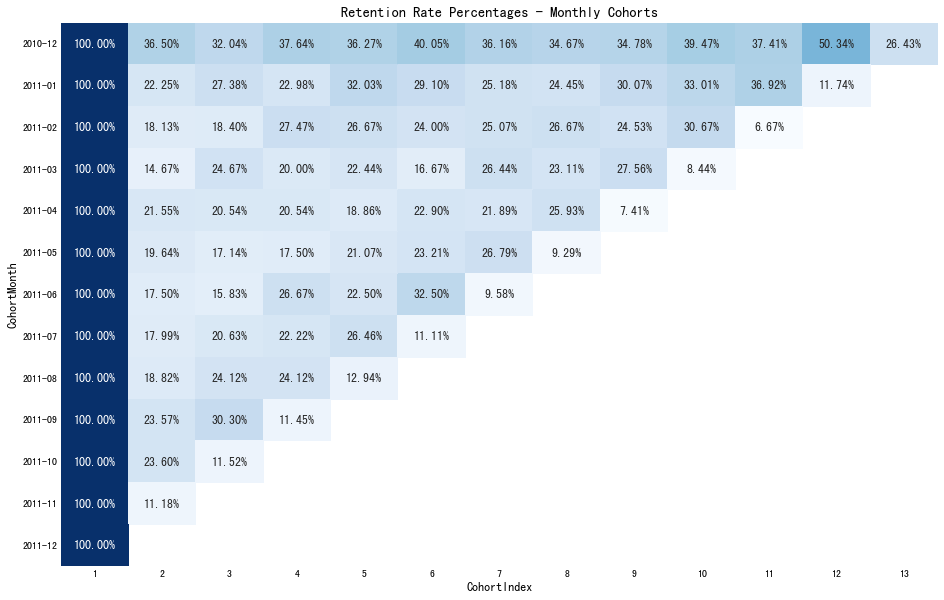

In [70]:
plt.rcParams["axes.facecolor"] = "white"
fig, ax = plt.subplots(figsize = (14, 10))

sns.heatmap(retention, cmap = "Blues", annot = True, fmt = ".2%", annot_kws = {"fontsize": 12}, cbar = False, ax = ax)

plt.title("Retention Rate Percentages - Monthly Cohorts")
plt.yticks(rotation = 0)
plt.show()

有40.05%的顾客在2011年1月首次购物，并持续五个月一直使用。

In [71]:
customer_per_month = df.groupby("CohortMonth")["CustomerID"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([4298, 4259, 3937, 3581, 3284, 3114, 2925, 2685, 2405, 2108, 1658,
       1283,  874])

In [72]:
customer_in_month = df.groupby("CohortIndex")["CustomerID"].nunique()
customer_in_month

CohortIndex
1     4298
2      961
3      930
4      907
5      890
6      866
7      795
8      710
9      665
10     633
11     503
12     488
13     231
Name: CustomerID, dtype: int64

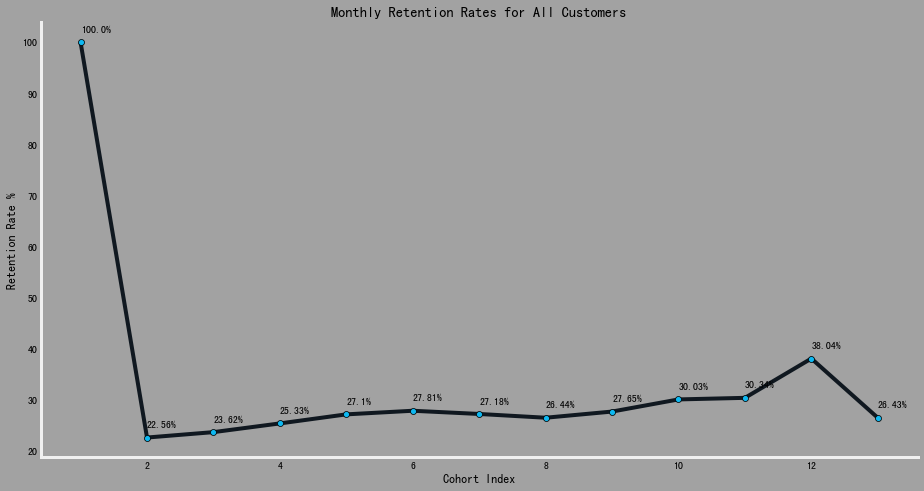

In [73]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (14, 8), facecolor = "#A2A2A2")
ax.grid(False)
x = customer_in_month.index
y = 100*(customer_in_month / customers)

sns.lineplot(x = x, y = y,  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

for x, y in zip(x, y):
    plt.text(x, y + 2, s = str(round(y, 2)) + "%")

plt.xlabel("Cohort Index")
plt.ylabel("Retention Rate %")
plt.title("Monthly Retention Rates for All Customers")
sns.despine()
plt.show()

可以看到留存值在12月会升高，可能其他的节日也会，这里只去分析最后一个月的情况 :)

来看看所有批次用户的消费

In [74]:
# 按照Cohort分的组去计算每组里面的顾客数和总的消费额
monthly_customer_price_df = df.groupby("InvoiceMonth").agg({"TotalPrice": "sum","CustomerID": "nunique"})

monthly_customer_price_df

,TotalPrice,CustomerID
InvoiceMonth,,
2010-12-01,477001.27,874
2011-01-01,402460.88,728
2011-02-01,384935.12,746
2011-03-01,501435.63,959
2011-04-01,389147.37,843
2011-05-01,578653.77,1039
2011-06-01,502033.11,981
2011-07-01,495787.75,937
2011-08-01,512410.08,920


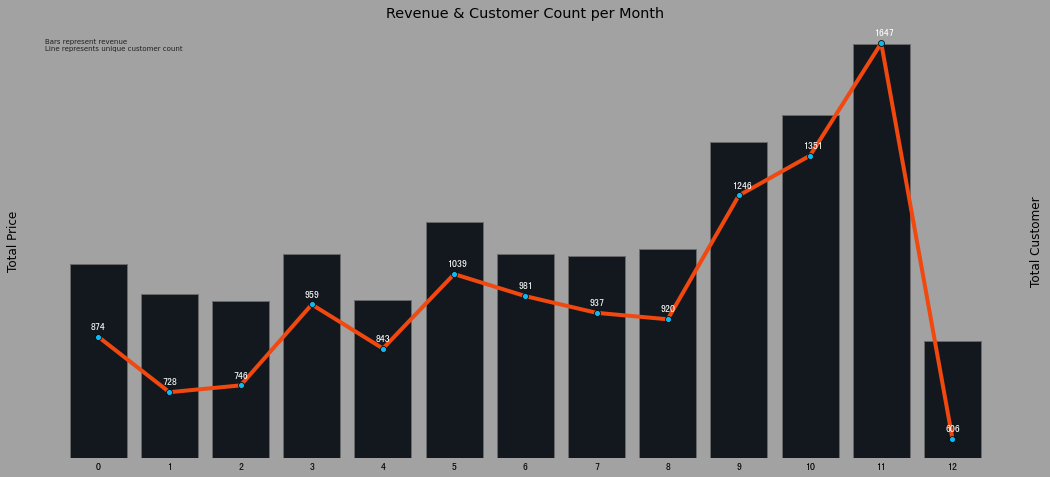

In [78]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.TotalPrice, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.CustomerID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "Times New Roman")
ax.set_ylabel("Total Price", fontname = "Times New Roman")
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman")
ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", 
        fontsize = 7, alpha = 0.8, fontname = "Times New Roman")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.CustomerID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()


# Part 2: Pareto Principle
![](https://upload.wikimedia.org/wikipedia/commons/e/eb/Pareto_principle.png)

这里用到2-8定律就是看看两个方面：
-  80% of company's revenue comes from 20% of total customers.

-  80% of company's revenue comes from 20% of total products.


In [79]:
def prepare_pareto_data(df, col, price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price, ascending = False)

    df_price["CumulativePercentage"] = (df_price[price].cumsum() / df_price[price].sum() * 100).round(2)
    
    return df_price

In [84]:
from matplotlib.ticker import PercentFormatter
def create_pareto_plot(df, col, price, log = True):
    
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150, facecolor = "#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
    ax.set_xlabel(subject, fontname = "Times New Roman")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

In [85]:
customer_price = prepare_pareto_data(df, "CustomerID", "TotalPrice") # 就是按照顾客id分组，然后计算总花费，排序，计算累计的占比

customer_price.head(10)

,TotalPrice,CumulativePercentage
CustomerID,,
14646.0,189796.00,2.65
14911.0,129795.43,4.46
12415.0,81455.09,5.60
14156.0,81329.92,6.73
18102.0,80619.70,7.86
17511.0,78595.72,8.95
15311.0,57178.46,9.75
13089.0,56618.82,10.54
14096.0,52147.65,11.27


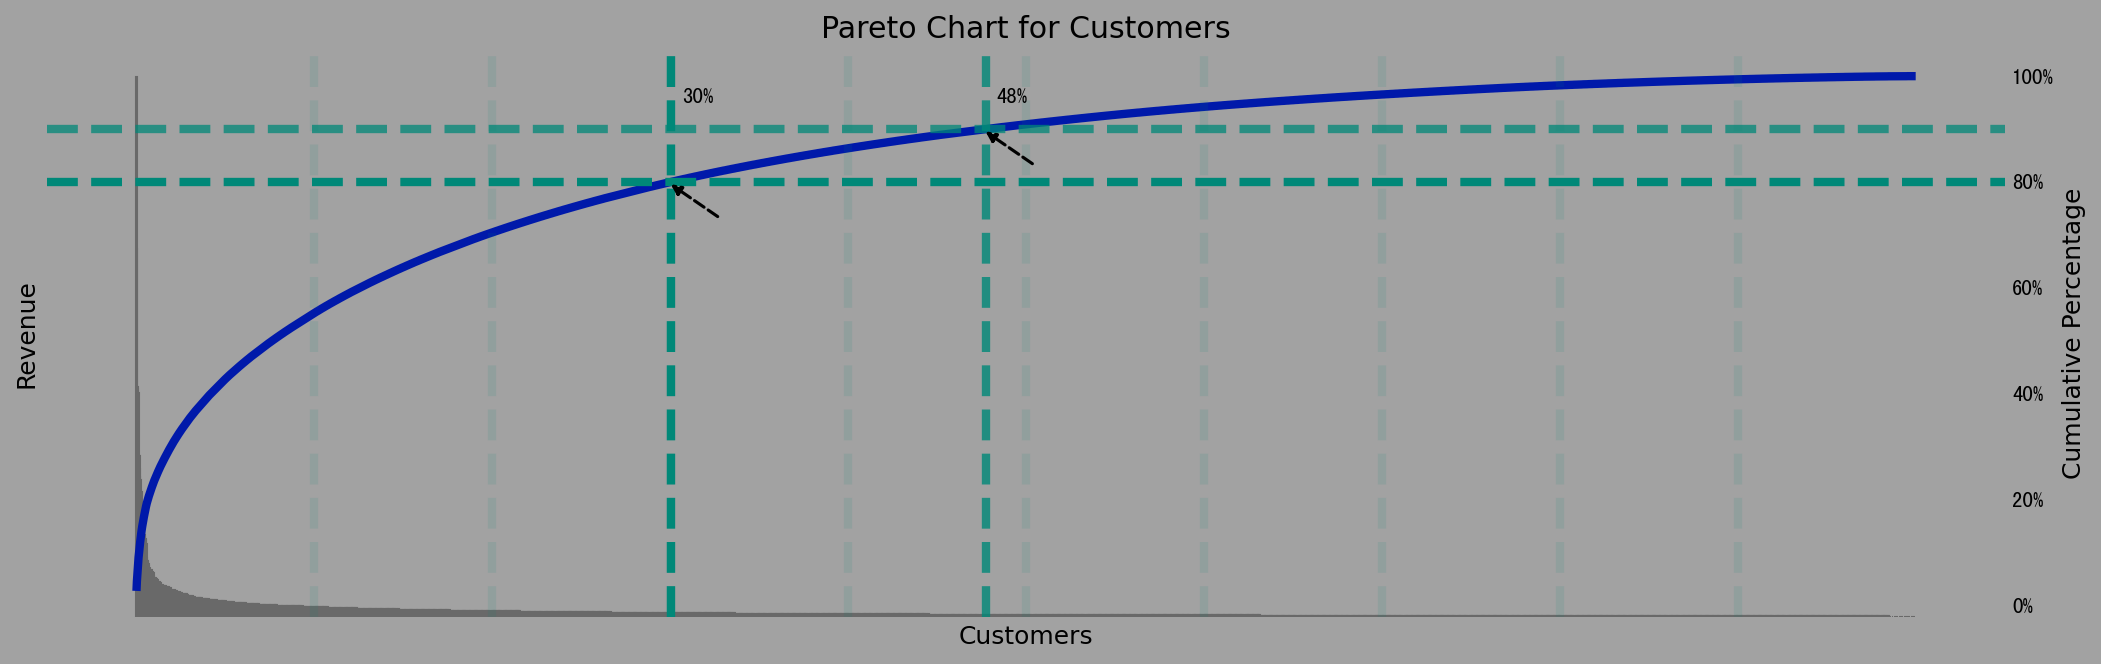

In [86]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = False)

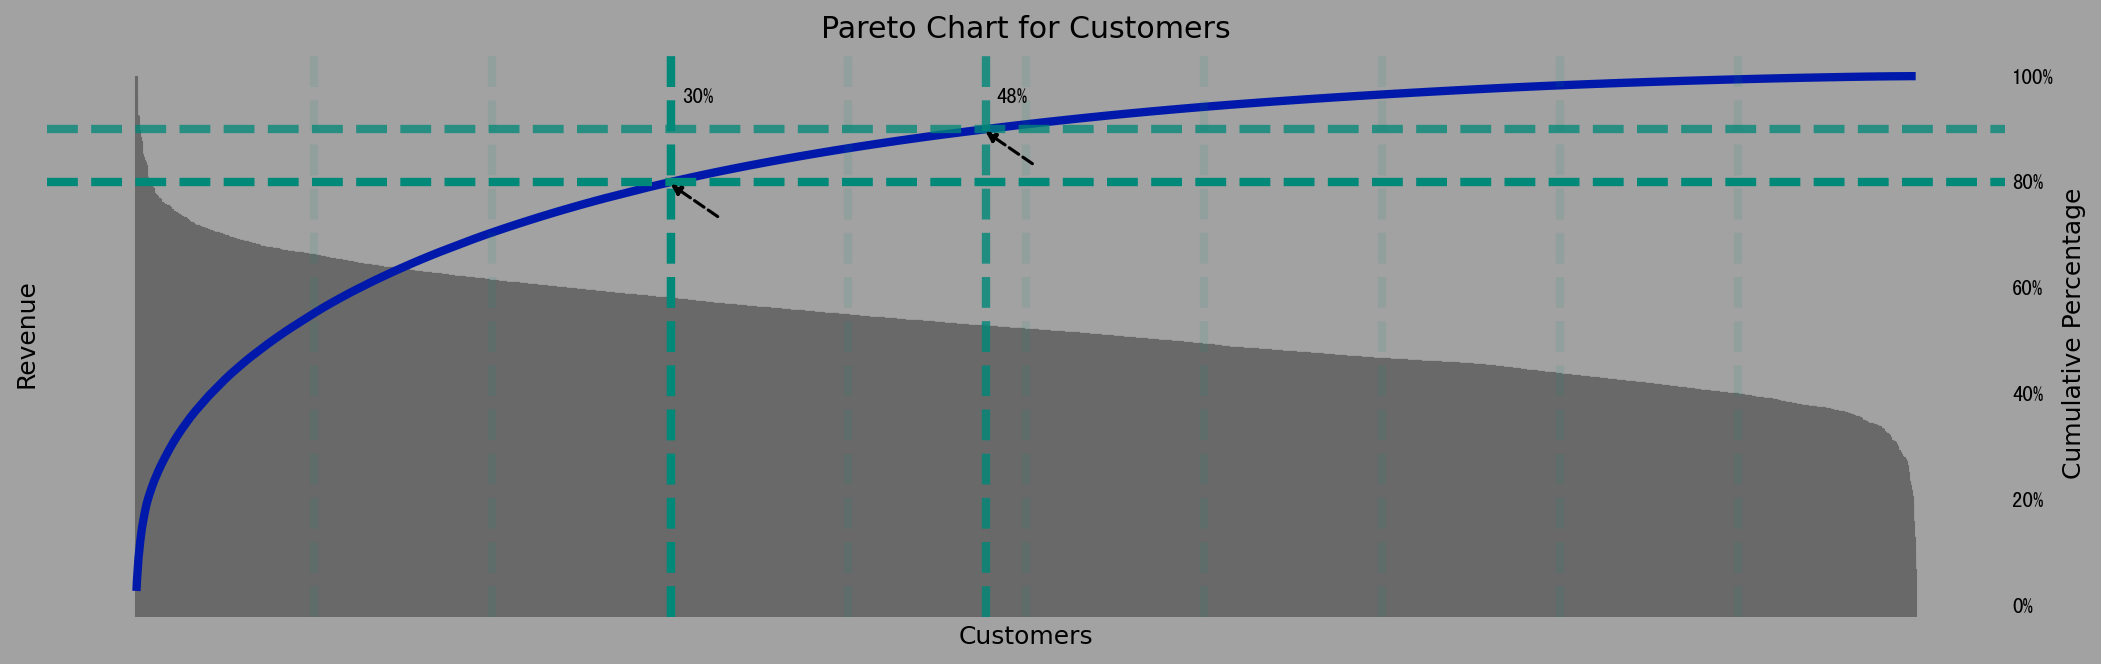

In [87]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = True)

那个商品的2-8定律就是同理的方法 :)

# Part 3: RFM Analysis



- https://zhuanlan.zhihu.com/p/98488644

RFM看的三个指标：
- 最近一次充值距离现在的时间 (Recency)：这个值越小对我们来说价值越大；
- 某段时间内充值频率次数 (Frequency)：这个值越大越好
- 某段时间内充值金额 (Monetary)3个维度；这个值越大越好


In [88]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [121]:
last_day = df.InvoiceDate.max() + dt.timedelta(days = 1)
last_day

Timestamp('2011-12-10 12:50:00')

In [90]:
rfm_table = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                         "InvoiceNo": "nunique",
                                         "TotalPrice": "sum"})

rfm_table.rename(columns = {"InvoiceDate": "Recency",
                            "InvoiceNo": "Frequency",
                            "TotalPrice": "Monetary"}, inplace = True)

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,4060.40
12348.0,75,4,1437.24
12349.0,19,1,1417.60
12350.0,310,1,294.40
12352.0,36,7,1385.74


In [91]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)
# 这里就是对变量范围进行切割，然后对应贴上设置好的标签
rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels) # 越小越好
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels) # 越大越好
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels) # 越大越好

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12347.0,2,7,4060.40,5,5,5
12348.0,75,4,1437.24,2,4,4
12349.0,19,1,1417.60,4,1,4
12350.0,310,1,294.40,1,1,2
12352.0,36,7,1385.74,3,5,4


In [92]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15
12348.0,75,4,1437.24,2,4,4,244,10
12349.0,19,1,1417.60,4,1,4,414,9
12350.0,310,1,294.40,1,1,2,112,4
12352.0,36,7,1385.74,3,5,4,354,12


然后接下来就是一系列针对RFM的可视化分析：

In [93]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15,Champions
12348.0,75,4,1437.24,2,4,4,244,10,At-Risk
12349.0,19,1,1417.60,4,1,4,414,9,Promising
12350.0,310,1,294.40,1,1,2,112,4,Hibernating
12352.0,36,7,1385.74,3,5,4,354,12,Loyal Customers


In [94]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

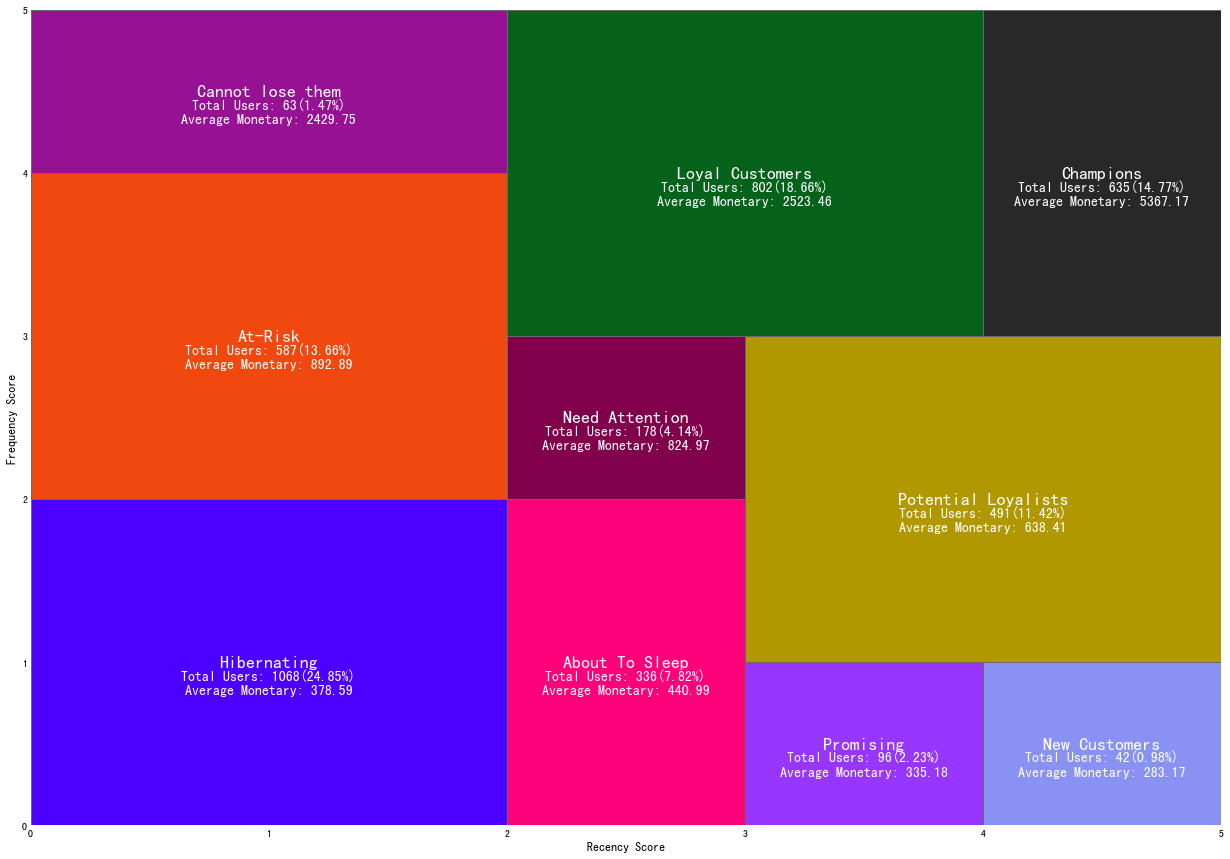

In [95]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

In [96]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

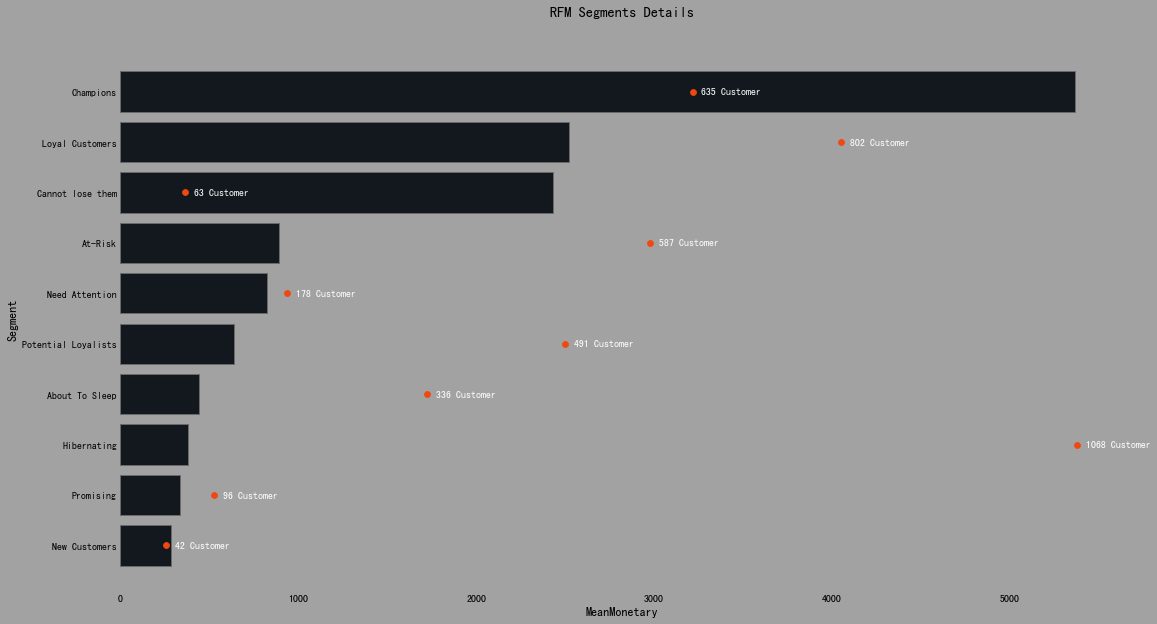

In [97]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanMonetary, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")


ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [111]:
rfm = rfm_table2.groupby("Segment").agg({"CustomerID": "nunique", 
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "Monetary": "mean"})
rfm.rename(columns = {"CustomerID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis = 1, color = "#D60000")

Segment,About To Sleep,At-Risk,Cannot lose them,Champions,Hibernating,Loyal Customers,Need Attention,New Customers,Potential Loyalists,Promising
Segment Size,336.00,587.00,63.00,635.00,1068.00,802.00,178.00,42.00,491.00,96.00
Recency,53.06,152.81,134.65,6.01,216.59,33.30,52.03,7.17,17.18,23.55
Frequency,1.14,2.85,8.30,12.04,1.09,6.39,2.30,1.00,1.99,1.00
Monetary,440.99,892.89,2429.75,5367.17,378.59,2523.46,824.97,283.17,638.41,335.18


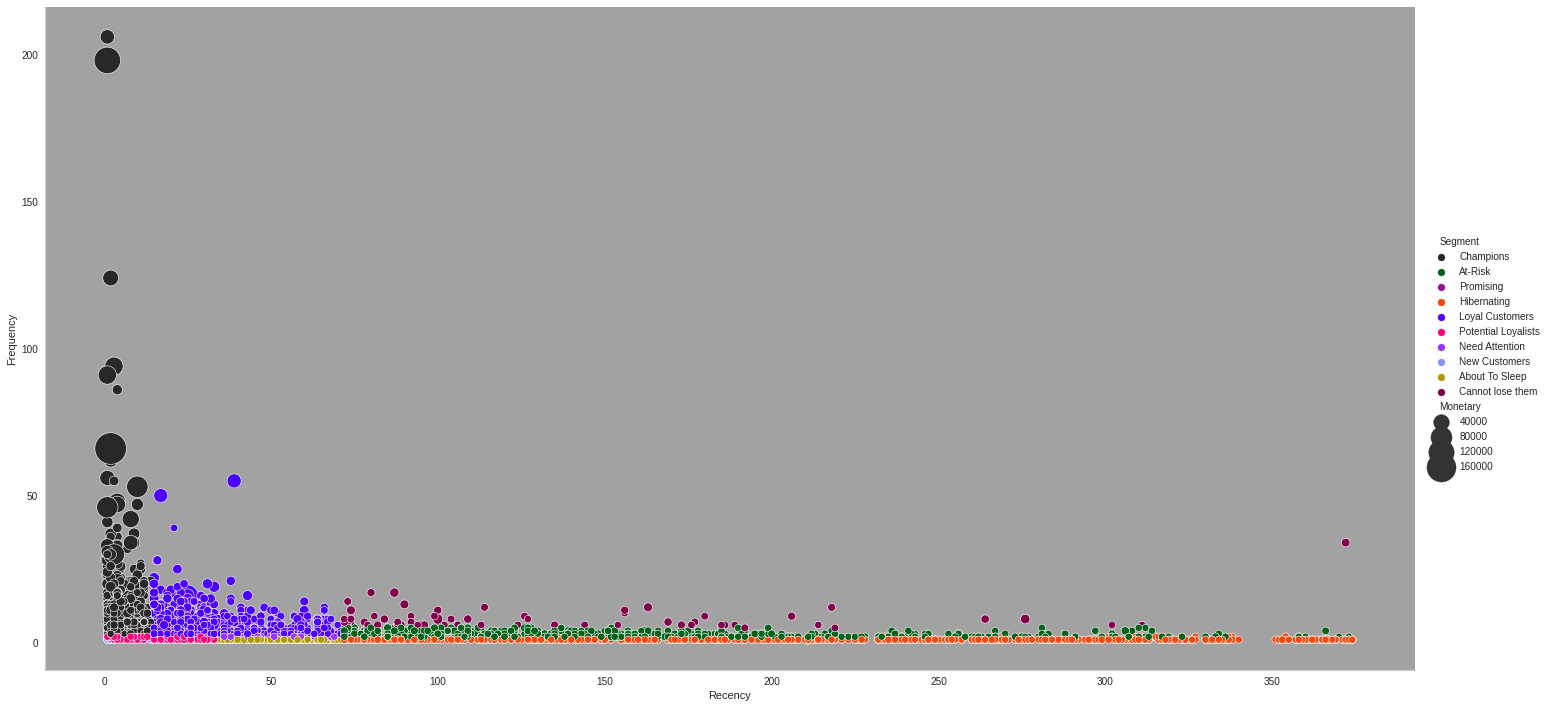

In [112]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = False

sns.relplot(x = "Recency", y = "Frequency", hue = "Segment", size = "Monetary", data = rfm_table2, palette = palette,
            height = 10, aspect = 2, sizes = (50, 1000))

plt.show()

In [113]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

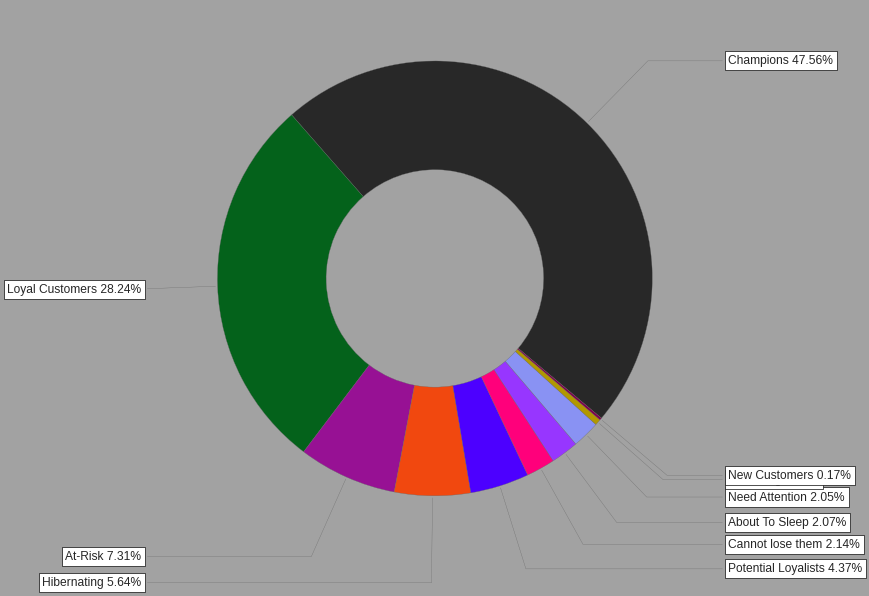

In [115]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

可以从饼图中看出47.5%的收入来自Champions群体，28%的收入来自Loyal Customers群体，这两个群体已经占了75%的收入。

In [116]:
rfm_clustering = rfm_table2[["Recency", "Frequency", "Monetary", "Segment"]]

for col in ["Recency", "Frequency", "Monetary"]:
    
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1, 1))
    
rfm_melted = pd.melt(rfm_clustering, id_vars = "Segment", value_vars = ["Recency", "Frequency", "Monetary"],
                     var_name = "RFM", value_name = "Value")

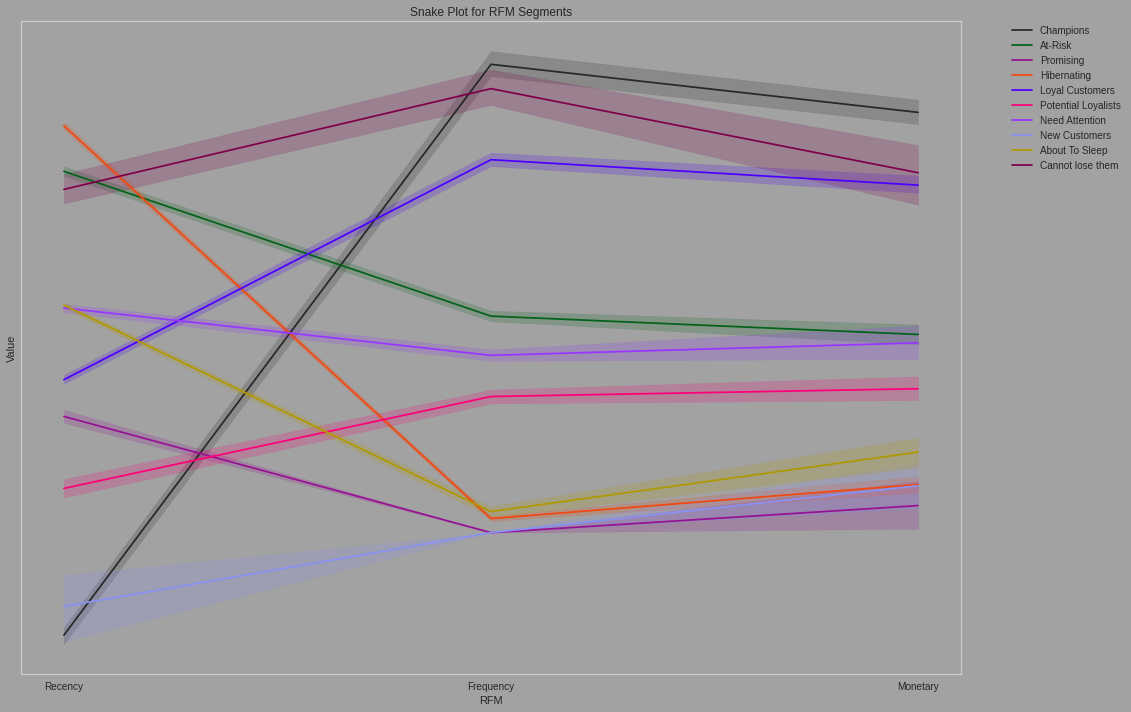

In [117]:

fig, ax = plt.subplots(figsize = (15, 12), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.lineplot(x = "RFM", y = "Value", hue = "Segment", data = rfm_melted, palette = palette)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments")
plt.show()

肘型法则先确定聚类数，然后再拿轮廓分析。

- https://en.wikipedia.org/wiki/Elbow_method_(clustering)

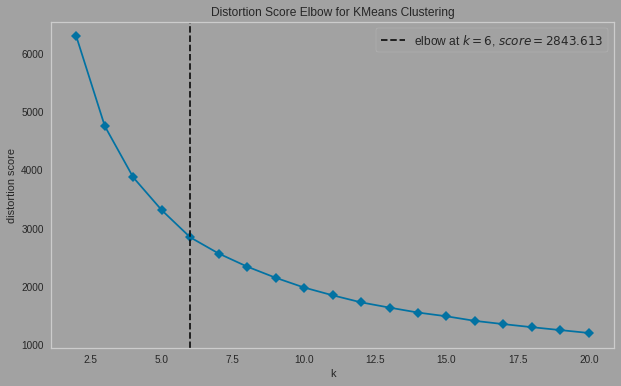

In [118]:
from yellowbrick.cluster import KElbowVisualizer

features = ["Recency", "Frequency", "Monetary"]

kmeans_ = KMeans(init = "k-means++", random_state = 42)

fig, ax = plt.subplots(figsize = (9, 6), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")
ax.grid(False)

visualizer = KElbowVisualizer(kmeans_, k = (2, 21), timings = False)

visualizer.fit(rfm_clustering[features]) 
visualizer.show()


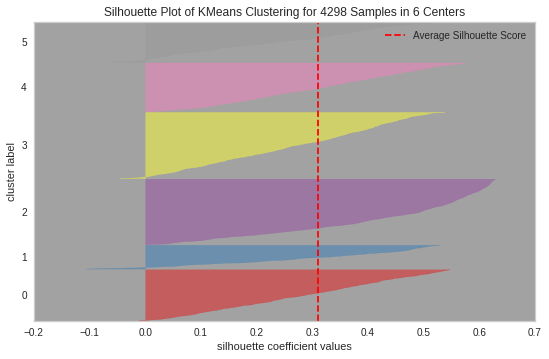

In [125]:
from yellowbrick.cluster import SilhouetteVisualizer
kmeans = KMeans(n_clusters = 6, random_state = 42) 
kmeans.fit(rfm_clustering[features])
cluster = kmeans.labels_
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(rfm_clustering[features]) 
visualizer.poof()

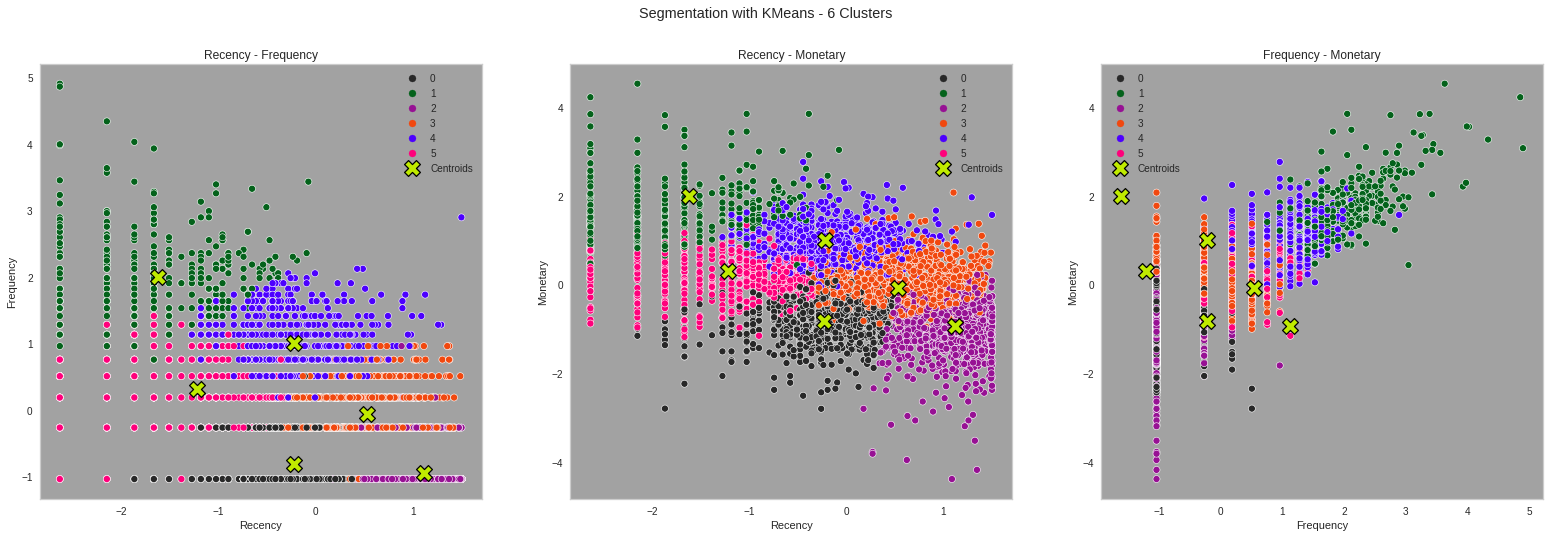

In [119]:
kmeans = KMeans(n_clusters = 6, random_state = 42) 
kmeans.fit(rfm_clustering[features])
cluster = kmeans.labels_

fig, axes = plt.subplots(1, 3, figsize = (24, 8))

from itertools import combinations


for i, feature in list(enumerate(combinations(["Recency", "Frequency", "Monetary"], 2))):

    sns.scatterplot(x = rfm_clustering[feature[0]], y = rfm_clustering[feature[1]], hue = cluster, 
                    palette = palette[: len(set(cluster))], ax = axes[i]).set_title(feature[0] + " - " + feature[1])

    sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1],
                    s = 250, color = '#C0EB00', label = 'Centroids', marker = "X", ax = axes[i], edgecolor = "black")

plt.suptitle("Segmentation with KMeans - 6 Clusters")
for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.grid(False)
    
plt.show()

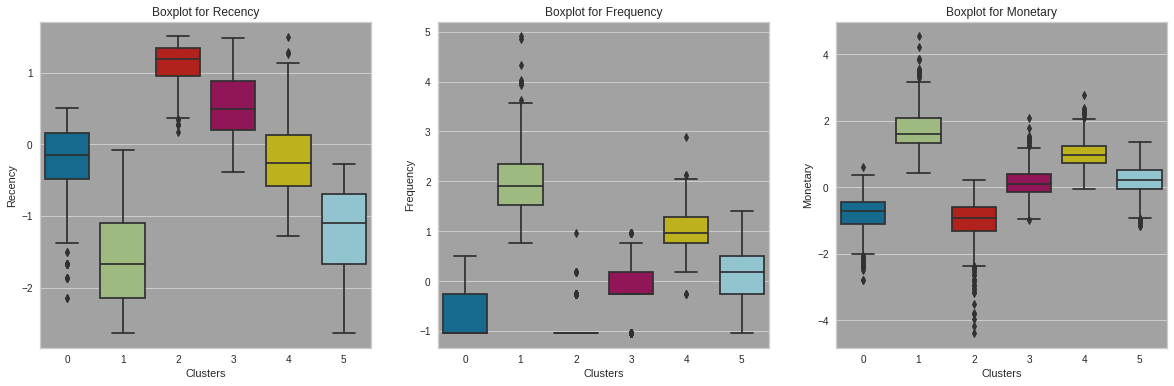

In [109]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.set_xlabel("Clusters")
    
sns.boxplot(x = cluster, y = "Recency", data = rfm_clustering, ax = axes[0]).set_title("Boxplot for Recency")
sns.boxplot(x = cluster, y = "Frequency", data = rfm_clustering, ax = axes[1]).set_title("Boxplot for Frequency")
sns.boxplot(x = cluster, y = "Monetary", data = rfm_clustering, ax = axes[2]).set_title("Boxplot for Monetary")

plt.show()

In [126]:
plt.rcdefaults()

# Part 4: Forecasting with Prophet